In [35]:
import qcodes as qc
import numpy as np
import matplotlib.pyplot as plt
from qcodes.data.data_set import load_data
import scipy.signal as signal
import scipy
#from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.plots.pyqtgraph import QtPlot

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy import integrate 

import math
from lmfit import Model
import qcodes.dataset.experiment_container as exc
#from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_run_spec, load_by_id

# Functions

In [36]:
def charge_data(id_1): # opens the data 
	'''
    Opens database experiment
    Parameters
    ----------
    id_1: int.
        database id.
    Returns
    -------
    integer: 1d array.
        number of trace
    X: 2d array.
         reflectometry traces in I.
    Y: 2d array.
         reflectometry traces in Q.
    sweep: 1d array.
        Trace time in us.
    '''

	dataset=load_by_id(id_1)

	integer=np.unique(dataset.get_parameter_data()["Distance"]["integer"])
	X=(dataset.get_parameter_data()["I"]["I"])
	Y=(dataset.get_parameter_data()["Q"]["Q"])
	sweep=(dataset.get_parameter_data()["RF_sweep"]["RF_sweep"] )[0]	 

	return integer,X, Y, sweep
def moving_average(a, n=20) :
	'''
    Moving average on array a
    Parameters
    ----------
    a: 1d array.
        array with data.
    n: int.
        length of the moving average. When n=20 a moving average is perform on array a every 20 points
    Returns
    -------
    1d array.
        moving average of array a
    '''
	ret = np.cumsum(a, dtype=float)
	ret[n:] = ret[n:] - ret[:-n]
	return ret[n - 1:] / n 
def IQ_plot(id_1,jupyter_name,sweep, X,Y,signal_start,signal_end, bg_start,bg_end):
	'''
    Plots maximums over two different time intervals in the IQ plane from the traces taken.
    Calculate the center of the signal and std for the maximums over both time intervals.
    The first interval si a mixture between signal and background.
    The second interval corresponds to only background since the bleep (spin up) has already happened.
    Parameters
    ----------
    id_1: int.
        database id.
    integer: 1d array.
        number of trace
    jupyter_name: string.
         title of the plot.
    X: 2d array.
         reflectometry traces in I.
    Y: 2d array.
         reflectometry traces in Q.
    sweep: 1d array.
        Trace time in us.
    signal_start: float.
        start of the first interval in us.
    signal_end: float.
        end of the first interval in us.
    bg_start: float.
        start of the second interval in us.
    bg_end: float.
        end of the second interval in us.
    Returns
    -------
    maximum_X: float.
        mean in I of the maximums during first interval.
    maximum_Y: float.
        mean in Q of the maximums during first interval.
    background_X: float.
        mean in I of the maximums during second interval.
    background_Y: float.
        mean in I of the maximums during second interval.
    '''
	maximum_X=np.zeros(len(X))
	maximum_Y=np.zeros(len(X))

	background_X=np.zeros(len(X))
	background_Y=np.zeros(len(X))

	for a in range(len(X)):
		minim= np.where(sweep>= signal_start)[0][0]
		maxim= np.where(sweep>= signal_end)[0][0]
		maximum_X[a]=X[a][minim:maxim].min()
		maximum_Y[a]=Y[a][minim:maxim].max()

		minim= np.where(sweep>= bg_start)[0][0]
		maxim= np.where(sweep>= bg_end)[0][0]
		background_X[a]=X[a][minim:maxim].min()
		background_Y[a]=Y[a][minim:maxim].max()
		
	fig_width_pt = 320.0  # Get this from LaTeX using \showthe\columnwidth
	inches_per_pt = 1.0/72.27				# Convert pt to inch
	golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
	fig_width = fig_width_pt*inches_per_pt	# width in inches
	fig_height = fig_width		# height in inches
	fig_size =	[fig_width,fig_height]
	plt.rcParams['legend.fontsize'] = 8
	plt.rcParams['figure.figsize'] = fig_size
		
	plt.axis("Equal")
	plt.scatter(maximum_X,maximum_Y ,label="signal.max",alpha=0.9,s=19)
	plt.scatter(background_X,background_Y,label="background.max",alpha=0.3,s=10)
	

	plt.xlabel("I_max (V)")
	plt.ylabel("Q_max (V)")
	plt.title(str(id_1)+" "+str(jupyter_name))

	plt.legend()

		
	theta = np.linspace(0, 2*np.pi, 100)

	
	stand_dev_maximum=0
	
	for b in range(len(maximum_X)):
		stand_dev_maximum=stand_dev_maximum+np.sqrt((maximum_X[b]-np.mean(maximum_X))**2+(maximum_Y[b]-np.mean(maximum_Y))**2)
	
	
	r = stand_dev_maximum/len(maximum_X)

	circlex = r*np.cos(theta)+np.mean(maximum_X)
	circley= r*np.sin(theta)+np.mean(maximum_Y)
	plt.plot(circlex,circley,'k')

	stand_dev_off=0
	for b in range(len(maximum_X)):
		stand_dev_off=stand_dev_off+np.sqrt((background_X[b]-np.mean(background_X))**2+(background_Y[b]-np.mean(background_Y))**2)

	r = stand_dev_off/len(maximum_X)

	circlex = r*np.cos(theta)+np.mean(background_X)
	circley= r*np.sin(theta)+np.mean(background_Y)
	plt.plot(circlex,circley,'k')
	plt.show()
	return maximum_X,maximum_Y,background_X,background_Y 
def projection(integer,X, Y, sweep,angle):
	'''
    projects IQ data into an axis
    Parameters
    ----------
    integer: 1d array.
        number of trace
    X: 2d array.
         reflectometry traces in I.
    Y: 2d array.
         reflectometry traces in Q.
    sweep: 1d array.
        Trace time in us.
    angle: float.
        angle in radians between I axis and axis in which the signal is going to be projected onto.
    Returns
    -------
    projected: 2d array.
        IQ traces projected to best angle.
    projected1: 2d array.
        IQ traces projected perpendicularly to best angle. 
    '''
	X=np.resize(X, (len(integer),len(sweep))) 
	Y=np.resize(Y, (len(integer),len(sweep)))
	projected=np.zeros((len(integer),len(sweep)))
	projected1=np.zeros((len(integer),len(sweep)))
	for a in range(int(len(integer))):
		projected[a]=X[a]*np.cos(angle)+Y[a]*np.sin(angle)
		projected1[a]=-X[a]*np.sin(angle)+Y[a]*np.cos(angle)
	return projected, projected1 # 
def model_fit1( datax, datay, function, title,xlabel,ylabel,plot, init={}, bounds={},**kwargs):
	'''
    Fits data to any function
    Parameters
    ----------
    datax: 1d array.
        x- axis from the data to be fitted
    datay: 1d array.
        y- axis from the data to be fitted
    function: python function
         function to be fitted
    title: string.
        title of the plot.
    xlabel: string.
        xlabel of the plot.
    ylabel: string.
        ylabel of the plot.
    plot: bool.
        True to plot, False to dont plot
    Returns
    -------
    out.best_values: 1d array.
        value of the fitted parameters.
    errors: 1d array.
        std of the parameters fitted
    '''
	from lmfit import Model
	gmodel = Model(function)
	params = gmodel.make_params()
	
	for param in init.keys():
		if param in params:
			params[param].value = init[param]

	for param in bounds.keys():
		if param in params:
			params[param].min = init[param][0]
			params[param].max = init[param][1]
	
	out = gmodel.fit(datay,params, x=datax,sigma=2, **kwargs)
	dely = out.eval_uncertainty(x=datax,sigma=2)
  

	if plot:
		plt.xlabel(xlabel, {'color': 'k', 'fontsize': 15}, )
		plt.ylabel(ylabel, {'color': 'k', 'fontsize': 15})
		plt.xticks( color='k', size=12)
		plt.yticks( color='k', size=12)
		plt.title("Model "+title,size=16)
		plt.plot(datax, out.best_fit, 'r-', label='best fit')
		plt.scatter(datax , datay)
		#plt.fill_between(datax , out.best_fit-dely, out.best_fit+dely,color="#ABABAB",label='$\sigma$ uncertainty band')
		plt.legend(loc='best')

		plt.show()
  
	keys=list(params.valuesdict().keys() )

	error = {}
	for i in range(len(keys)):
		try:
		  error[keys[i]+"_std"] = np.absolute(out.covar[i][i])**0.5
		except:
		  error[keys[i]+"_std"] = 0
	return out.best_values, error
def gaussian_function(x, mu, sigma):
	'''
    Gaussian function
    Parameters
    ----------
    datax: 1d array.
        x- axis from the data to be fitted
    mu: float.
        median of the gaussian
    sigma: float.
         standard deviation of the gaussian
    Returns
    -------
    1d array.
        Gaussian fucntion
    '''
	return 1/sigma/np.sqrt(2*np.pi)*np.exp(-1/2*((x-mu)/sigma)**2)
def fourier_transf(I,acqtime ):
    I=I-np.mean(I)
    #plt.plot(I)
    fourier = np.fft.fft(I)
    n = I.size
    timestep = 1/n*acqtime
    freq = np.fft.fftfreq(n, d=timestep)
    #plt.scatter(freq, fourier)
    plt.xlabel("Frequency (Hz)")
    return freq[0:int(n/2)], fourier[0:int(n/2)]
def simulate_ss_out(A,std_down,std_up ,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, plot_trace = 0):
    #v2 + add T_out
    
    # time list 
    #n_points_time = 1952 #number of points
    #t_max = 2000 #mus
    t = np.array(np.linspace(0,2000,n_points_time))
    
    # Indexes of time during which we will take the max of the trace + for the bg
    
    meas_time=t[(t<=t_max)]
    #minim_time_bg= np.where(list_t>= 1460)[0][0]
    #maxim_time_bg= np.where(list_t>= 1860)[0][0]
        
    # assign spin
    choose_spin = np.random.binomial(1,A,1) #create 1 with proba A and 0 with proba (1-A)
    
    if choose_spin == 1 : # spin down because A = <P_down>
    # create a blip of spin down i.e. noise centred at signal_low and take the max
        line_spindown = moving_average(np.random.normal(signal_low,std_down,len(meas_time)),t_int) 
        
        
        max_ss = np.max(line_spindown)
        #max_ss_bg = np.max(line_spindown[minim_time_bg:maxim_time_bg])
        
        if plot_trace == 1 :
            plt.title('Spin down with Tint = %f, T_in = %f'%(t_int,t_in))
            plt.plot(list_t,line_spindown)
            plt.legend()
            #plt.ylim((-0.05,0.25))
            plt.grid()
    
    if choose_spin == 0 : #spin up
    # create a blip of spin up and take the max
        line_spinup =simple_ss_n_in_out(meas_time, t_in, t_out,std_down, std_up,t_int,signal_low, signal_high)
        #line_spinup = ss_n_in_out_scaled_2std(t,t_in,t_out,t_bw,std_down,std_up,t_int,signal_low,signal_high)
        max_ss = np.max(line_spinup)
        #max_ss_bg = np.max(line_spinup[minim_time_bg:maxim_time_bg])
        
        if plot_trace == 1 :
            plt.title('Spin up with Tint = %f, T_in = %f'%(t_int,t_in))
            plt.plot(t_list,line_spinup)
            plt.legend()
            #plt.ylim((-0.05,0.25))
            plt.grid()
            
    return(max_ss,choose_spin)  
def simple_ss_n_in_out(t, t_in, t_out, std_low,std_high,t_int,signal_low =0, signal_high = 1):
    ss_x=np.zeros(len(t))
    
    t_leave=np.random.exponential(t_out) #random t_out time
    t_enter=np.random.exponential(t_in) #random t_in time
    
    i_leave = np.where(t<=t_leave)[0][-1]    
    i_enter = np.where(t<=t_enter+t_leave)[0][-1]
    
    
    ss_x[0:i_leave] = signal_low + np.random.normal(0,std_low,len(t[0:i_leave])) 

    if i_enter == i_leave : #means T_enter = 0
        ss_x[i_leave:] =  signal_low + np.random.normal(0,std_low,len(t[i_leave:]))

    else : 
        ss_x[i_leave:i_enter] = signal_high + np.random.normal(0,std_high,len(t[i_leave:i_enter]))
        ss_x[i_enter:] = signal_low + np.random.normal(0,std_high,len(t[i_enter:])) #+1 to make it continuous]

    # test another type of rolling avergae
    ss_x = moving_average(ss_x,t_int)
    return ss_x
def histogram_data (data,Tint, number_bins =60, range_min = 0, range_max = 0.3):
    x = np.array(data.maximum_distance)
    y = np.array(data.maximum_bg)
    
    #make histogram
    hist_max, bin_edges_max = np.histogram(x, bins=number_bins, range=(range_min,range_max))    
    hist_max_bg, bin_edges_max_bg = np.histogram(y, bins=number_bins,range=(range_min,range_max) ) 
    
    plt.figure()
    plt.hist(x, bins=number_bins, range=(range_min,range_max),alpha = 0.7, label='signal')
    #plt.hist(y, bins=number_bins, range=(range_min,range_max), alpha = 0.7,label='background' )
    plt.title("histogram at Tint = %f us" %Tint) 
    plt.show()
    plt.legend()
    #plt.savefig('1histogram.png')
    
    
    #plt.figure()
    plt.plot(get_inter_bins(bin_edges_max),hist_max, label='signal')
    #plt.plot(get_inter_bins(bin_edges_max_bg),hist_max_bg,label ='background')
    plt.legend()
    plt.xlabel('Distance(V)')
    plt.grid()
    #plt.title('Tint = 2.5us')

    return(get_inter_bins(bin_edges_max),hist_max,get_inter_bins(bin_edges_max_bg),hist_max_bg)
# Create list with center of bin_edges so that we can plot the histogram as a curve 
def get_inter_bins(bins):
    res = []
    for i in range (len(bins)-1):
        res.append( 1/2*(bins[i]+bins[i+1]))
    return(res)
def simulate_histogram_updown_Virginia(A,range_min,range_max,std_down,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60,plot_histo = 1):
    #returns the histograms of spin up and down
    
    max_ss_up = []
    max_ss_down = []
    

    # Do many traces and get max
    for i in range(n_traces):
        ss_readout = simulate_ss_out(A,std_down,std_up,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, 0)

        if ss_readout[1] == 1 : #choose_spin = 1 so spin is down
            max_ss_down.append(ss_readout[0])
            

        if ss_readout[1] == 0 : #choose_spin = 0 so spin is up
            max_ss_up.append(ss_readout[0])
            
        
        #if i==np.int(n_traces/2):
        #    print('Progress>50%')
    
    max_ss_up = np.array(max_ss_up)
    max_ss_down = np.array(max_ss_down)
    
    ma = np.append(max_ss_up,max_ss_down)
   
    

    hist_max_ss_up, bin_edges_max_ss_up = np.histogram(max_ss_up,bins=num_bins,range = (range_min,range_max))    
    hist_max_ss_down, bin_edges_max_ss_down = np.histogram(max_ss_down, bins=num_bins,range=(range_min,range_max) )

    if plot_histo == 1:
        # Plot the histogram 
        plt.hist(max_ss_up,bins=num_bins,range = (range_min,range_max), label = 'spin up', alpha = 0.5)  
        plt.hist(max_ss_down,bins=num_bins,range = (range_min,range_max), label = 'spin down', alpha = 0.5)
        plt.xlabel("Signal")
        plt.ylabel("Probability")
        plt.title('Simulated histogram')
        print('Parameters for the simulation :')
        print('T_int = %f us, T_in = %f us, T_out = %f us, T_bw = %f us' %(t_int,t_in,t_out,t_bw))
        print('A = %f, std = %f'%(A,std))
        plt.legend()
        plt.show()
        #plt.savefig('1histogram.png')


    #return(get_inter_bins(bin_edges_max_ss),hist_max_ss,ma)
    return(get_inter_bins(bin_edges_max_ss_up),hist_max_ss_up,get_inter_bins(bin_edges_max_ss_down),hist_max_ss_down)

def fidelity_Virginia(threshold_signal, A, range_min,range_max,std_down,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60,plot_histo = 1, plot_distrib=0):
    print(t_int)
    res = simulate_histogram_updown_Virginia(A,range_min,range_max,std_bg,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins , plot_histo)
    
    histo_up = (res[0],res[1])
    histo_down = (res[2],res[3])
    
    #plot_distrib = 0
    if plot_distrib == 1:
        # -----------------------
        plt.plot(histo_up[0], histo_up[1],label='spin up signal')
        plt.plot(histo_down[0], histo_down[1],label='spin down signal')


        # Caption
        #------------------------
        plt.legend()
        plt.xlabel("Signal")
        plt.ylabel("Probability")
        plt.title('Simulated histogram Tin=%f'%t_in)
        #plt.savefig('2_histogram_Tin=%f.png'%t_in)

    f_hist_up = interp1d(histo_up[0], histo_up[1],kind='cubic')
    f_hist_down = interp1d(histo_down[0], histo_down[1],kind='cubic')
    
    def f_total(x):
        return(f_hist_up(x)+f_hist_down(x))
    
    fidelity_up = []
    fidelity_down = []
    fidelity_error = []
    
    if type(threshold_signal)==np.ndarray or type(threshold_signal)==list:
        for signal in threshold_signal:
            integ_up = integrate.quad(f_hist_up, np.min(histo_up[0]), signal)
            integ_down = integrate.quad(f_hist_down, signal, np.max(histo_down[0]))

            #integ_total = integrate.quad(f_total, range_min, range_max)
            integ_total = np.array(integrate.quad(f_hist_up, np.min(histo_up[0]), np.max(histo_up[0]))) + np.array(integrate.quad(f_hist_down,  np.min(histo_down[0]),  np.max(histo_down[0])))

            #print(integ_total)
            error_total_integral = np.abs((histo_up[0][2]-histo_up[0][1])*n_traces - integ_total[0])
            
            fidelity_up.append(1-integ_up[0]/integ_total[0])
            fidelity_down.append(1-integ_down[0]/integ_total[0])
            fidelity_error.append(error_total_integral)
            
        return(fidelity_down,fidelity_up,fidelity_error)

    
    elif type(threshold_signal)==float or type(threshold_signal)==int:
        integ_up = integrate.quad(f_hist_up, np.min(histo_up[0]), signal)
        integ_down = integrate.quad(f_hist_down, signal, np.max(histo_down[0]))

        #integ_total = integrate.quad(f_total, range_min, range_max)
        integ_total = np.array(integrate.quad(f_hist_up, np.min(histo_up[0]), np.max(histo_up[0]))) + np.array(integrate.quad(f_hist_down,  np.min(histo_down[0]),  np.max(histo_down[0])))

        #print(integ_total)
        error_total_integral = np.abs((histo_up[0][2]-histo_up[0][1])*n_traces - integ_total[0])
           
        return(1-integ_down[0]/integ_total[0],1-integ_up[0]/integ_total[0],error_total_integral)

In [37]:
# perform a fit using lmfit given inital values and bounds
def fit(x, y, func, init={}, bounds={}, fixed = {}, steps = {}, step_size = 1e-7):
    
    gmodel = Model(func)
    params = gmodel.make_params()
    
    for param in fixed.keys():
        if param in params:
            params[param].set(fixed[param],vary=False)
    
    for param in init.keys():
        if param in params:
            params[param].value = init[param]

    for param in bounds.keys():
        if param in params:
            params[param].min = bounds[param][0]
            params[param].max = bounds[param][1]
    
    for param in steps.keys():
        if param in params:
            params[param].set(brute_step=steps[param])
    
            
    #return gmodel.fit(y, params, x=x,method='brute')
    return (gmodel.fit(y, params, x=x, fit_kws = {'epsfcn':step_size}))



def simulate_histogram_out(A,range_min,range_max,std_down,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60,plot_histo = 1): 
    max_ss_up = []
    max_ss_down = []
    max_ss_bg = []

    # Do many traces and get max
    for i in range(n_traces):
        
        # Plot the traces for the first 5 traces 
        #if i<5 :
        #    ss_readout = simulate_ss_out(A,std_down,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, 1)

        #else :
        ss_readout = simulate_ss_out(A,std_down,std_up,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time, 0)
            
        if ss_readout[1] == 1 : #choose_spin = 1 so spin is down
            max_ss_down.append(ss_readout[0])
            #max_ss_bg.append(ss_readout[1])

        if ss_readout[1] == 0 : #choose_spin = 0 so spin is up
            max_ss_up.append(ss_readout[0])
            #max_ss_bg.append(ss_readout[1])
        
        #if i==np.int(n_traces/2):
        #    print('Progress>50%')
    
    ma = np.append(np.array(max_ss_up),np.array(max_ss_down))
    #max_ss_bg = np.array(max_ss_bg)


    hist_max_ss, bin_edges_max_ss = np.histogram(ma,bins=num_bins,range = (range_min,range_max))    
    #hist_max_ss_bg, bin_edges_max_ss_bg = np.histogram(max_ss_bg, bins=num_bins,range=(range_min,range_max) )
    
    bin_axis_ss= bin_edges_max_ss[0:-1]+( bin_edges_max_ss[1]- bin_edges_max_ss[0])/2
    normalisation=( bin_edges_max_ss[1]- bin_edges_max_ss[0])*n_traces
    
    
    #print('number of traces for bg =',len(max_ss_bg),'number of up traces =',len(max_ss_up))
    if plot_histo == 1:
        # Plot the histogram 
        plt.figure()
        plt.hist(ma,bins=num_bins,label='total', alpha = 0.6,range = (range_min,range_max))
        #plt.hist(max_ss_bg,bins=num_bins ,label='background', alpha = 0.5,range = (range_min,range_max))
        plt.xlabel("Signal")
        plt.ylabel("Probability")
        plt.title('Simulated histogram')
        print('Parameters for the simulation :')
        print('T_int = %f us, T_in = %f us, T_out = %f us' %(t_int,t_in,t_out))
        print('A = %f, std = %f'%(A,std_down))
        plt.legend()
        plt.show()
        #plt.savefig('1histogram.png')

        #Plot the histogram as lines 
        plt.title('Simulated histogram as lines')
        plt.plot(get_inter_bins(bin_edges_max_ss),hist_max_ss, label='signal')
        plt.plot(get_inter_bins(bin_edges_max_ss_bg),hist_max_ss_bg,label ='background')
        plt.legend()
        plt.xlabel('Distance(V)')
        plt.grid()
        #plt.title('Tint = 2.5us')

    return(bin_axis_ss,hist_max_ss/normalisation)


def fit_histogram_v2(x,A,range_min,range_max,std_low, std_up,signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins = 60, plot_histo = 0):
    #interpolate the histogram after generating it
    
    #print('x=',x)
    #print('signal_high=',signal_high)
    #print("std_up",std_up)
    #print("A",A)
    (inter_bin_simu, hist_max_simu) =  simulate_histogram_out(A,range_min,range_max,std_low,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins ,plot_histo  )
    f_hist_inter = interp1d(inter_bin_simu, hist_max_simu, kind='cubic')
    
    return(f_hist_inter(x))

In [38]:
def simple_ss_n_in_out_sim(t, t_in, t_out, std_low, std_up, signal_low =0, signal_high = 1):
    ss_x=np.zeros(len(t))
    
    t_leave=np.random.exponential(t_out) #random t_out time
    t_enter=np.random.exponential(t_in) #random t_in time
    
    i_leave = np.where(t<=t_leave)[0][-1]    
    i_enter = np.where(t<=t_enter+t_leave)[0][-1]
    
    
    ss_x[0:i_leave] = signal_low + np.random.normal(0,std_low,len(t[0:i_leave])) 

    if i_enter == i_leave : #means T_enter = 0
        ss_x[i_leave:] =  signal_low + np.random.normal(0,std_low,len(t[i_leave:]))

    else : 
        ss_x[i_leave:i_enter] = signal_high + np.random.normal(0,std_low,len(t[i_leave:i_enter]))
        ss_x[i_enter:] = signal_low + np.random.normal(0,std_low,len(t[i_enter:])) #+1 to make it continuous]

    # test another type of rolling avergae
   # ss_x = moving_average(ss_x,t_int)
    return ss_x



def simulate_distance(A,std_down,std_up ,signal_low,signal_high,t_out,t_in,n_points_time, n_traces,sweep):
    ss = []
    spin_number=np.empty(0)
    
    for i in range(n_traces):
        choose_spin = np.random.binomial(1,A,1) #create 1 with proba A and 0 with proba (1-A)
        spin_number = np.append(spin_number, choose_spin)
        
        if choose_spin == 1 : # spin down because A = <P_down>
        # create a blip of spin down i.e. noise centred at signal_low and take the max
            line_spin_down = signal_low + np.random.normal(0,std_down,n_points_time)
            ss.append(line_spin_down )
            
            
        if choose_spin == 0 : #spin up
        # create a blip of spin up and take the max
            line_spin_up =simple_ss_n_in_out_sim(sweep, t_in, t_out,std_down, std_up,signal_low, signal_high)
            
            ss.append( line_spin_up )
            
    ss=np.array(ss)
    return(ss,spin_number)  

def standard_deviation_error(x):
    mean=np.mean(x)
    n=len(x)
    mu_4=1/n*np.sum((x-mean)**4)
    se_s2=np.sqrt(1/n*(mu_4-(n-3)/(n-1)*np.std(x)**4))
    return se_s2

Standard deviation of standard deviation

$se(s^2)= \sqrt{\frac{1}{n}(\mu_4 -\frac{n-3}{n-1}\sigma^4)}$

where $\mu_4= E(X-\mu)^4=\frac{1}{n}[(x_1-\mu)^4+...]$

# Open file

In [39]:
import json
id_1=2
with open('JPA_off_vs_power_'+str(id_1)+'.json', 'r') as file:
    signal_parameters_fit_read=json.load(file)

In [40]:
A=signal_parameters_fit_read["A"]
std_low=signal_parameters_fit_read["std_bg"]
std_up=signal_parameters_fit_read["std_up"]
signal_low=signal_parameters_fit_read["mean_bg"]
signal_high=signal_parameters_fit_read["mean_up"]

t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]

In [41]:
signal_parameters_fit_read

{'mean_bg': -2.643739082239295,
 'std_bg': 0.10098707442424183,
 'mean_up': -2.5421098416887236,
 'std_up': 0.10386521514925602,
 't_int': 20,
 't_out': 52.616843137535675,
 'A': 0.500042687664294,
 't_in': 439.4829850723389}

In [8]:
185.7-20

165.7

# David method

In [9]:
# Generates distance

# SIMULATION- CREATE DATA

signal_low=signal_parameters_fit_read["mean_bg"]
signal_high=signal_parameters_fit_read["mean_up"]
std_bg=signal_parameters_fit_read["std_bg"]
std_up=signal_parameters_fit_read["std_up"]

#t_out= 31.160407033908214
#A=0.4630301498361565
#t_in= 185.78804551121178

t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]

A=signal_parameters_fit_read["A"]

n_traces=100000
n_points_time=1951
acquisition_time=2000

sweep=np.linspace(0,acquisition_time,n_points_time)



sim_distance, spin_sim= simulate_distance(A,std_bg,std_up ,signal_low,signal_high,t_out,t_in,n_points_time, n_traces,sweep)



## Loop in t_max and t_int

In [10]:

t_max=np.logspace(np.log10(100),np.log10(2000),101)
#t_max=np.linspace((300),(310),1)
factor=np.linspace((1),(50),41)

#print(factor)
factor = factor.astype(int)
print(factor)
visibility_2D_map=np.zeros((len(t_max), len(factor)))
fidelity_up_def=np.zeros((len(t_max), len(factor)))
fidelity_down_def=np.zeros((len(t_max), len(factor)))

for c in range(len(t_max)):

    ## Define your t_max
    #t_max=200
    n_point_max= np.where(sweep>= t_max[c])[0][0]

    to_remove=np.linspace(n_point_max,n_points_time-1,n_points_time-n_point_max )
    to_remove=to_remove.astype(int)
    sweep_rem = sweep[0:n_point_max]
    sim_distance_rem=np.delete(sim_distance, to_remove,1)

    for b in range(len(factor)):
        ## SIMULATION MOVING AVERAGE
        #factor=10
        sim_distance_40_rem=np.zeros((len(sim_distance_rem),len( moving_average(sim_distance_rem[0], factor[b]))))
        sweep_40_rem=np.zeros(len(moving_average(sim_distance_rem[0], factor[b])))

        for a in range(len(sim_distance_rem)):
            sim_distance_40_rem[a]=moving_average(sim_distance_rem[a], factor[b])

        sweep_40_rem=moving_average(sweep_rem, factor[b])



        # HISTOGRAM WITH SIMULATION
        maximum_sim_rem=np.zeros(len(sim_distance_40_rem))

        for a in range(len(sim_distance_rem)):
            minim= np.where(sweep_40_rem>= 0)[0][0]
            maxim= np.where(sweep_40_rem>= sweep_40_rem.max())[0][0]


            maximum_sim_rem[a]=sim_distance_40_rem[a][minim:maxim].max()
        range_min=maximum_sim_rem.min()
        range_max=maximum_sim_rem.max()

        ## fidelity with histogram


        epsilon=0.005
        signal_threshold = np.linspace(range_min + epsilon, range_max - epsilon,50)

        fidelity_up = []
        fidelity_down = []

        spin_up_maximums=maximum_sim_rem[np.where(spin_sim==0)[0]]
        spin_down_maximums=maximum_sim_rem[np.where(spin_sim==1)[0]]
        for signal in signal_threshold:

                    integ_up=len(np.where(spin_up_maximums<=signal)[0])
                    integ_down=len(np.where(spin_down_maximums>=signal)[0])

                    fidelity_up.append(1-integ_up/n_traces)
                    fidelity_down.append(1-integ_down/n_traces)


        visibility=np.array(fidelity_up)+np.array(fidelity_down)-1
        integer=np.where(visibility==visibility.max())[0][0]
        fidelity_up_def[c][b]=np.array(fidelity_up)[integer]
        fidelity_down_def[c][b]=np.array(fidelity_down)[integer]
        visibility_2D_map[c][b]=visibility.max()
    #print ("visibility",visibility_2D_map[c][b])
    print (c)
    #plt.plot(factor,visibility_2D_map[c],label="t_max="+str(t_max[c]))
    #plt.legend()
    #plt.show()

[ 1  2  3  4  5  7  8  9 10 12 13 14 15 16 18 19 20 21 23 24 25 26 27 29
 30 31 32 34 35 36 37 38 40 41 42 43 45 46 47 48 50]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
fidelity_down_def+fidelity_up_def-1

In [33]:
fidelity_up_def

array([[0.889]])

In [34]:
fidelity_down_def

array([[0.97601]])

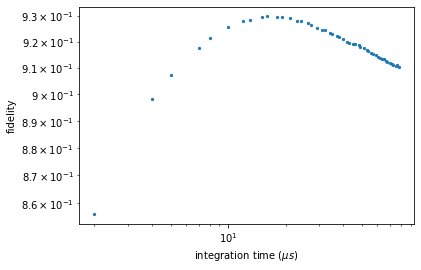

In [41]:
plt.scatter(factor[1:-1],(visibility_2D_map)[10][1:-1],  s=5)
plt.xlabel("integration time ($\mu s$)")
plt.ylabel("fidelity")
plt.xscale("log")
plt.yscale("log")

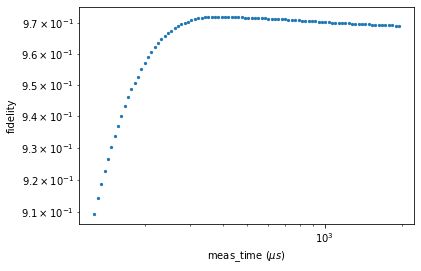

In [42]:
plt.scatter(t_max[8:-1],np.transpose(visibility_2D_map)[30][8:-1], label="t_max=1000", s=5)
plt.xlabel("meas_time $(\mu s)$")
plt.ylabel("fidelity")
plt.xscale("log")
plt.yscale("log")

C:\Users\virgi\QMT Dropbox\Virginia Ciriano\experiments\2_qubit_gate_raw_data\W19\2S28_1\Spin_fidelity_JPA_off_vs\fit_helpers_vir.py:210: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = ax.pcolormesh(Y, X, Z,vmin=level_min,vmax=level_max,  cmap='viridis')


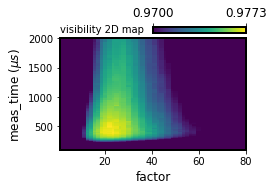

In [43]:
from fit_helpers_vir import *

%matplotlib inline
D2_map(factor,t_max,(visibility_2D_map),0.97,visibility_2D_map.max(),"linear", "visibility 2D map","factor","meas_time $(\mu s)$","2D_MAP")



C:\Users\virgi\QMT Dropbox\Virginia Ciriano\experiments\2_qubit_gate_raw_data\W19\2S28_1\DATA_ANALYSIS\Spin_fidelity_JPA_off_vs\fit_helpers_vir.py:210: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = ax.pcolormesh(Y, X, Z,vmin=level_min,vmax=level_max,  cmap='viridis')


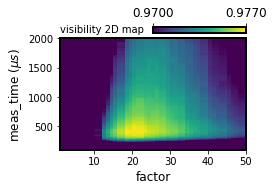

In [11]:
from fit_helpers_vir import *

%matplotlib inline
D2_map(factor,t_max,(visibility_2D_map),0.97,visibility_2D_map.max(),"linear", "visibility 2D map","factor","meas_time $(\mu s)$","2D_MAP")



In [12]:
np.savez('./visibility_2D_map_JPA_OFF_' +str(id_1)+ '.npz', factor=factor, t_max=t_max, visibility_2D_map=visibility_2D_map, fidelity_up_E=fidelity_up_def, fidelity_down_E=fidelity_down_def)


In [13]:
id_1=2
np.load('./visibility_2D_map_JPA_OFF_' +str(id_1)+ '.npz').files

factor=np.load('./visibility_2D_map_JPA_OFF_' +str(id_1)+ '.npz')["factor"]
t_max=np.load('./visibility_2D_map_JPA_OFF_' +str(id_1)+ '.npz')["t_max"]
visibility_2D_map=np.load('./visibility_2D_map_JPA_OFF_' +str(id_1)+ '.npz')["visibility_2D_map"]


max visibility = 0.9682599999999999 at -2.583355758304804


C:\Users\virgi\AppData\Local\Temp/ipykernel_23064/1790732549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')


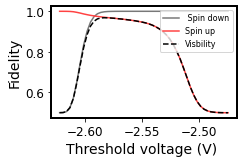

In [14]:
plt.figure()
fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27				# Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# width in inches
fig_height = fig_width*golden_mean		# height in inches
fig_size =	[fig_width,fig_height]
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = fig_size

plt.plot(signal_threshold,fidelity_down, color=(120/255,120/255,120/255), label=r' Spin down')#Fidelity$_{\downarrow}$')


plt.plot(signal_threshold,fidelity_up, color= (255/255,66/255,66/255), label=r'Spin up')#Fidelity$_{\uparrow}$' )
plt.plot(signal_threshold,np.array(fidelity_up)+np.array(fidelity_down)-1,'--',label='Visbility',c='k')

plt.legend(loc=1, fontsize=8)
plt.xlabel("Threshold voltage (V) ", {'color': 'k', 'fontsize': 14})
plt.ylabel("Fidelity", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)

plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')
print("max visibility =", np.max(np.array(fidelity_up)+np.array(fidelity_down)-1),'at', signal_threshold[np.argmax(np.array(fidelity_up)+np.array(fidelity_down)-1)])

C:\Users\virgi\AppData\Local\Temp/ipykernel_28308/2032102579.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("histogram.png",dpi=600, bbox_inches = "tight", rasterized='True')


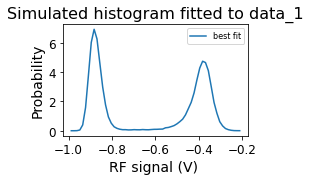

In [20]:
# Plot simulation as curve
# -----------------------
t_int=factor
t_max=400
num_bins=60
bins, histo=simulate_histogram_out(A,range_min,range_max,std_low,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins , 0)
#f_hist_inter = interp1d(bins,histo, kind='cubic')
x=np.linspace(-3,0,1000)
#plt.plot(x,f_hist_inter(x), label='best fit')
plt.plot(bins, histo, label='best fit')

# Caption
#------------------------
plt.legend()
plt.xlabel("Signal")
plt.ylabel("Probability")
plt.title('Simulated histogram vs data_ Tint=%f'%t_int)

plt.xlabel("RF signal (V) ", {'color': 'k', 'fontsize': 14})
plt.ylabel("Probability", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)
#plt.ylim(0,30)
plt.title("Simulated histogram fitted to data_1",size=16)
plt.savefig("histogram.png",dpi=600, bbox_inches = "tight", rasterized='True')


0.98549

In [ ]:
# 

# Constance method

In [24]:
# CALCULATE FIDELITY AS CONSTANCE

epsilon = 0.01
#epsilon is so that we make sure we don't integrate out of the boundaries of the interpolated function
#n_traces = int(n_traces/factor_ntraces)

signal_threshold = np.linspace(range_min + epsilon, range_max - epsilon,50)


fidelity_down, fidelity_up, error = fidelity_Virginia(signal_threshold,A,range_min,range_max,std_low,std_up, signal_low,signal_high,t_int,t_out,t_in,t_max,n_points_time,n_traces,num_bins , 0)


10


C:\Users\virgi\AppData\Local\Temp/ipykernel_28308/1763152944.py:459: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ_total = np.array(integrate.quad(f_hist_up, np.min(histo_up[0]), np.max(histo_up[0]))) + np.array(integrate.quad(f_hist_down,  np.min(histo_down[0]),  np.max(histo_down[0])))
C:\Users\virgi\AppData\Local\Temp/ipykernel_28308/1763152944.py:455: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the positi

max visibility = 0.9857580609443393 at -0.7644694085148065


C:\Users\virgi\AppData\Local\Temp/ipykernel_28308/1790732549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')


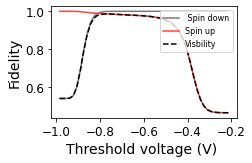

In [25]:
plt.figure()
fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27				# Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0		 # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# width in inches
fig_height = fig_width*golden_mean		# height in inches
fig_size =	[fig_width,fig_height]
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = fig_size

plt.plot(signal_threshold,fidelity_down, color=(120/255,120/255,120/255), label=r' Spin down')#Fidelity$_{\downarrow}$')


plt.plot(signal_threshold,fidelity_up, color= (255/255,66/255,66/255), label=r'Spin up')#Fidelity$_{\uparrow}$' )
plt.plot(signal_threshold,np.array(fidelity_up)+np.array(fidelity_down)-1,'--',label='Visbility',c='k')

plt.legend(loc=1, fontsize=8)
plt.xlabel("Threshold voltage (V) ", {'color': 'k', 'fontsize': 14})
plt.ylabel("Fidelity", {'color': 'k', 'fontsize': 14})
plt.xticks( color='k', size=12)
plt.yticks( color='k', size=12)

plt.savefig("fidelity.png",dpi=600, bbox_inches = "tight", rasterized='True')
print("max visibility =", np.max(np.array(fidelity_up)+np.array(fidelity_down)-1),'at', signal_threshold[np.argmax(np.array(fidelity_up)+np.array(fidelity_down)-1)])

In [26]:
visibility=np.array(fidelity_up)+np.array(fidelity_down)-1
visibility.max()

0.9857580609443393

# PSB simulation

In [42]:
import json
id_1=2
with open('JPA_off_vs_power_'+str(id_1)+'.json', 'r') as file:
    signal_parameters_fit_read=json.load(file)

In [43]:
A=signal_parameters_fit_read["A"]
std_low=signal_parameters_fit_read["std_bg"]
std_up=signal_parameters_fit_read["std_up"]
signal_low=signal_parameters_fit_read["mean_bg"]
signal_high=signal_parameters_fit_read["mean_up"]

t_in=signal_parameters_fit_read["t_in"]
t_out=signal_parameters_fit_read["t_out"]

In [44]:
signal_parameters_fit_read

{'mean_bg': -2.643739082239295,
 'std_bg': 0.10098707442424183,
 'mean_up': -2.5421098416887236,
 'std_up': 0.10386521514925602,
 't_int': 20,
 't_out': 52.616843137535675,
 'A': 0.500042687664294,
 't_in': 439.4829850723389}

In [45]:
185.7-20

165.7

In [46]:
# Generates distance

# SIMULATION- CREATE DATA

signal_low=signal_parameters_fit_read["mean_bg"]
signal_high=signal_parameters_fit_read["mean_up"]
std_bg=signal_parameters_fit_read["std_bg"]
std_up=signal_parameters_fit_read["std_up"]

#t_out= 31.160407033908214
#A=0.4630301498361565
#t_in= 185.78804551121178

t_in=200
t_out=0.001

A=signal_parameters_fit_read["A"]

n_traces=100000
n_points_time=1951
acquisition_time=2000

sweep=np.linspace(0,acquisition_time,n_points_time)



sim_distance, spin_sim= simulate_distance(A,std_bg,std_up ,signal_low,signal_high,t_out,t_in,n_points_time, n_traces,sweep)



In [32]:

t_max=np.linspace(3,15,14)
#t_max=np.linspace((300),(310),1)
factor=np.linspace((1),(2),2)

#print(factor)
factor = factor.astype(int)
print(factor)
visibility_2D_map=np.zeros((len(t_max), len(factor)))
fidelity_up_def=np.zeros((len(t_max), len(factor)))
fidelity_down_def=np.zeros((len(t_max), len(factor)))

for c in range(len(t_max)):


    n_point_max= np.where(sweep>= t_max[c])[0][0]

    to_remove=np.linspace(n_point_max,n_points_time-1,n_points_time-n_point_max )
    to_remove=to_remove.astype(int)
    sweep_rem = sweep[0:n_point_max]
    sim_distance_rem=np.delete(sim_distance, to_remove,1)

    for b in range(len(factor)):
        ## SIMULATION MOVING AVERAGE
        #factor=10
        sim_distance_40_rem=np.zeros((len(sim_distance_rem),len( moving_average(sim_distance_rem[0], factor[b]))))
        sweep_40_rem=np.zeros(len(moving_average(sim_distance_rem[0], factor[b])))

        for a in range(len(sim_distance_rem)):
            sim_distance_40_rem[a]=moving_average(sim_distance_rem[a], factor[b])

        sweep_40_rem=moving_average(sweep_rem, factor[b])



        # HISTOGRAM WITH SIMULATION
        maximum_sim_rem=np.zeros(len(sim_distance_40_rem))

        for a in range(len(sim_distance_rem)):
            minim= np.where(sweep_40_rem>= 0)[0][0]
            maxim= np.where(sweep_40_rem>= sweep_40_rem.max())[0][0]


            maximum_sim_rem[a]=sim_distance_40_rem[a][minim:maxim].max()
        range_min=maximum_sim_rem.min()
        range_max=maximum_sim_rem.max()

        ## fidelity with histogram


        epsilon=0.005
        signal_threshold = np.linspace(range_min + epsilon, range_max - epsilon,50)

        fidelity_up = []
        fidelity_down = []

        spin_up_maximums=maximum_sim_rem[np.where(spin_sim==0)[0]]
        spin_down_maximums=maximum_sim_rem[np.where(spin_sim==1)[0]]
        for signal in signal_threshold:

                    integ_up=len(np.where(spin_up_maximums<=signal)[0])
                    integ_down=len(np.where(spin_down_maximums>=signal)[0])

                    fidelity_up.append(1-integ_up/n_traces)
                    fidelity_down.append(1-integ_down/n_traces)


        visibility=np.array(fidelity_up)+np.array(fidelity_down)-1
        integer=np.where(visibility==visibility.max())[0][0]
        fidelity_up_def[c][b]=np.array(fidelity_up)[integer]
        fidelity_down_def[c][b]=np.array(fidelity_down)[integer]
        visibility_2D_map[c][b]=visibility.max()
    #print ("visibility",visibility_2D_map[c][b])
    print (c)
    #plt.plot(factor,visibility_2D_map[c],label="t_max="+str(t_max[c]))
    #plt.legend()
    #plt.show()

[1 2]
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [34]:
(fidelity_up_def+fidelity_down_def)/2

array([[0.864955, 0.88047 ],
       [0.87398 , 0.88911 ],
       [0.881675, 0.899745],
       [0.886325, 0.90692 ],
       [0.890495, 0.912485],
       [0.89318 , 0.916305],
       [0.89573 , 0.920635],
       [0.89888 , 0.92395 ],
       [0.90112 , 0.92669 ],
       [0.90314 , 0.929055],
       [0.90314 , 0.929055],
       [0.905015, 0.93041 ],
       [0.906135, 0.932195],
       [0.90793 , 0.933775]])

In [26]:
from fit_helpers_vir import *

%matplotlib inline
D2_map(factor,t_max,(visibility_2D_map),0.97,visibility_2D_map.max(),"linear", "visibility 2D map","factor","meas_time $(\mu s)$","2D_MAP")


array([0.])

In [30]:
n_point_max

1